In [1]:
# Import required libraries and set display configurations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from collections import Counter
import re
import string
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for high-resolution plots in Jupyter
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['axes.unicode_minus'] = False

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cpu
CUDA available: False


In [2]:
# Generate synthetic text dataset for classification task
def generate_text_data(n_samples=2000):
    """
    Generate synthetic text data with positive and negative sentiment
    """
    positive_words = [
        "excellent", "amazing", "wonderful", "fantastic", "brilliant",
        "outstanding", "incredible", "superb", "perfect", "great",
        "awesome", "magnificent", "superior", "delightful", "marvelous"
    ]

    negative_words = [
        "terrible", "awful", "horrible", "disgusting", "disappointing",
        "bad", "worst", "atrocious", "abysmal", "dreadful",
        "pathetic", "appalling", "disgusting", "inferior", "unsatisfactory"
    ]

    neutral_words = [
        "the", "is", "and", "or", "but", "in", "on", "at", "to", "for",
        "with", "by", "from", "up", "about", "into", "through", "during",
        "before", "after", "above", "below", "between", "among", "of", "a",
        "an", "this", "that", "these", "those", "i", "you", "he", "she",
        "it", "we", "they", "me", "him", "her", "us", "them", "my", "your"
    ]

    texts = []
    labels = []

    for i in range(n_samples):
        # Determine label and select words accordingly
        label = np.random.choice([0, 1])  # 0: negative, 1: positive
        text_length = np.random.randint(10, 30)  # Random text length

        text = []
        # Add sentiment words
        if label == 1:
            sentiment_word = np.random.choice(positive_words)
        else:
            sentiment_word = np.random.choice(negative_words)
        text.append(sentiment_word)

        # Add neutral words
        for _ in range(text_length - 1):
            word = np.random.choice(neutral_words)
            text.append(word)

        # Shuffle words to avoid positional bias
        np.random.shuffle(text)

        # Join to form sentence
        sentence = " ".join(text)
        texts.append(sentence)
        labels.append(label)

    return texts, labels

# Generate the text dataset
texts, labels = generate_text_data(n_samples=2000)

# Create a DataFrame
df = pd.DataFrame({
    'text': texts,
    'label': labels
})

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst 10 rows:")
print(df.head(10))
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nText length statistics:")
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
print(df['text_length'].describe())

Dataset shape: (2000, 2)

First 10 rows:
                                                text  label
0  disgusting me they an among between is among h...      0
1  for up she it disgusting or him up us is in he...      0
2  among through she at you with magnificent at s...      1
3  the an my she below wonderful she but him up w...      1
4  in it about them on this disgusting from your ...      0
5  among i my you about in to we an us is by me i...      1
6  with to below that after but you atrocious int...      0
7  i wonderful she before by into on is you her w...      1
8  after and below they above below on you or the...      1
9  wonderful that among you above during she and ...      1

Label distribution:
label
1    1064
0     936
Name: count, dtype: int64

Text length statistics:
count    2000.000000
mean       19.543000
std         5.795165
min        10.000000
25%        14.000000
50%        19.000000
75%        25.000000
max        29.000000
Name: text_length, dtype: float64

In [3]:
# Text preprocessing and vocabulary creation
def preprocess_text(text):
    """
    Basic text preprocessing
    """
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

def build_vocab(texts, min_freq=2):
    """
    Build vocabulary from texts
    """
    all_tokens = []
    for text in texts:
        tokens = preprocess_text(text).split()
        all_tokens.extend(tokens)

    # Count frequencies
    token_counts = Counter(all_tokens)

    # Create vocab with special tokens
    vocab = {'<PAD>': 0, '<UNK>': 1}  # Padding and Unknown tokens
    idx = 2
    for token, freq in token_counts.items():
        if freq >= min_freq:
            vocab[token] = idx
            idx += 1

    return vocab

def text_to_sequence(text, vocab, max_length=50):
    """
    Convert text to sequence of token indices
    """
    tokens = preprocess_text(text).split()
    sequence = []
    for token in tokens:
        if token in vocab:
            sequence.append(vocab[token])
        else:
            sequence.append(vocab['<UNK>'])

    # Pad or truncate to max_length
    if len(sequence) < max_length:
        sequence.extend([vocab['<PAD>']] * (max_length - len(sequence)))
    else:
        sequence = sequence[:max_length]

    return sequence

# Preprocess the data
df['processed_text'] = df['text'].apply(preprocess_text)

# Build vocabulary
vocab = build_vocab(df['processed_text'])
vocab_size = len(vocab)

print(f"Vocabulary size: {vocab_size}")
print(f"Sample vocabulary entries: {dict(list(vocab.items())[:10])}")

# Convert texts to sequences
max_length = 50
sequences = [text_to_sequence(text, vocab, max_length) for text in df['processed_text']]

# Convert to tensors
X = torch.tensor(sequences, dtype=torch.long)
y = torch.tensor(df['label'].values, dtype=torch.long)

print(f"Input tensor shape: {X.shape}")
print(f"Target tensor shape: {y.shape}")

Vocabulary size: 76
Sample vocabulary entries: {'<PAD>': 0, '<UNK>': 1, 'disgusting': 2, 'me': 3, 'they': 4, 'an': 5, 'among': 6, 'between': 7, 'is': 8, 'him': 9}
Input tensor shape: torch.Size([2000, 50])
Target tensor shape: torch.Size([2000])


Training set size: 1600
Test set size: 400
Batch size: 32


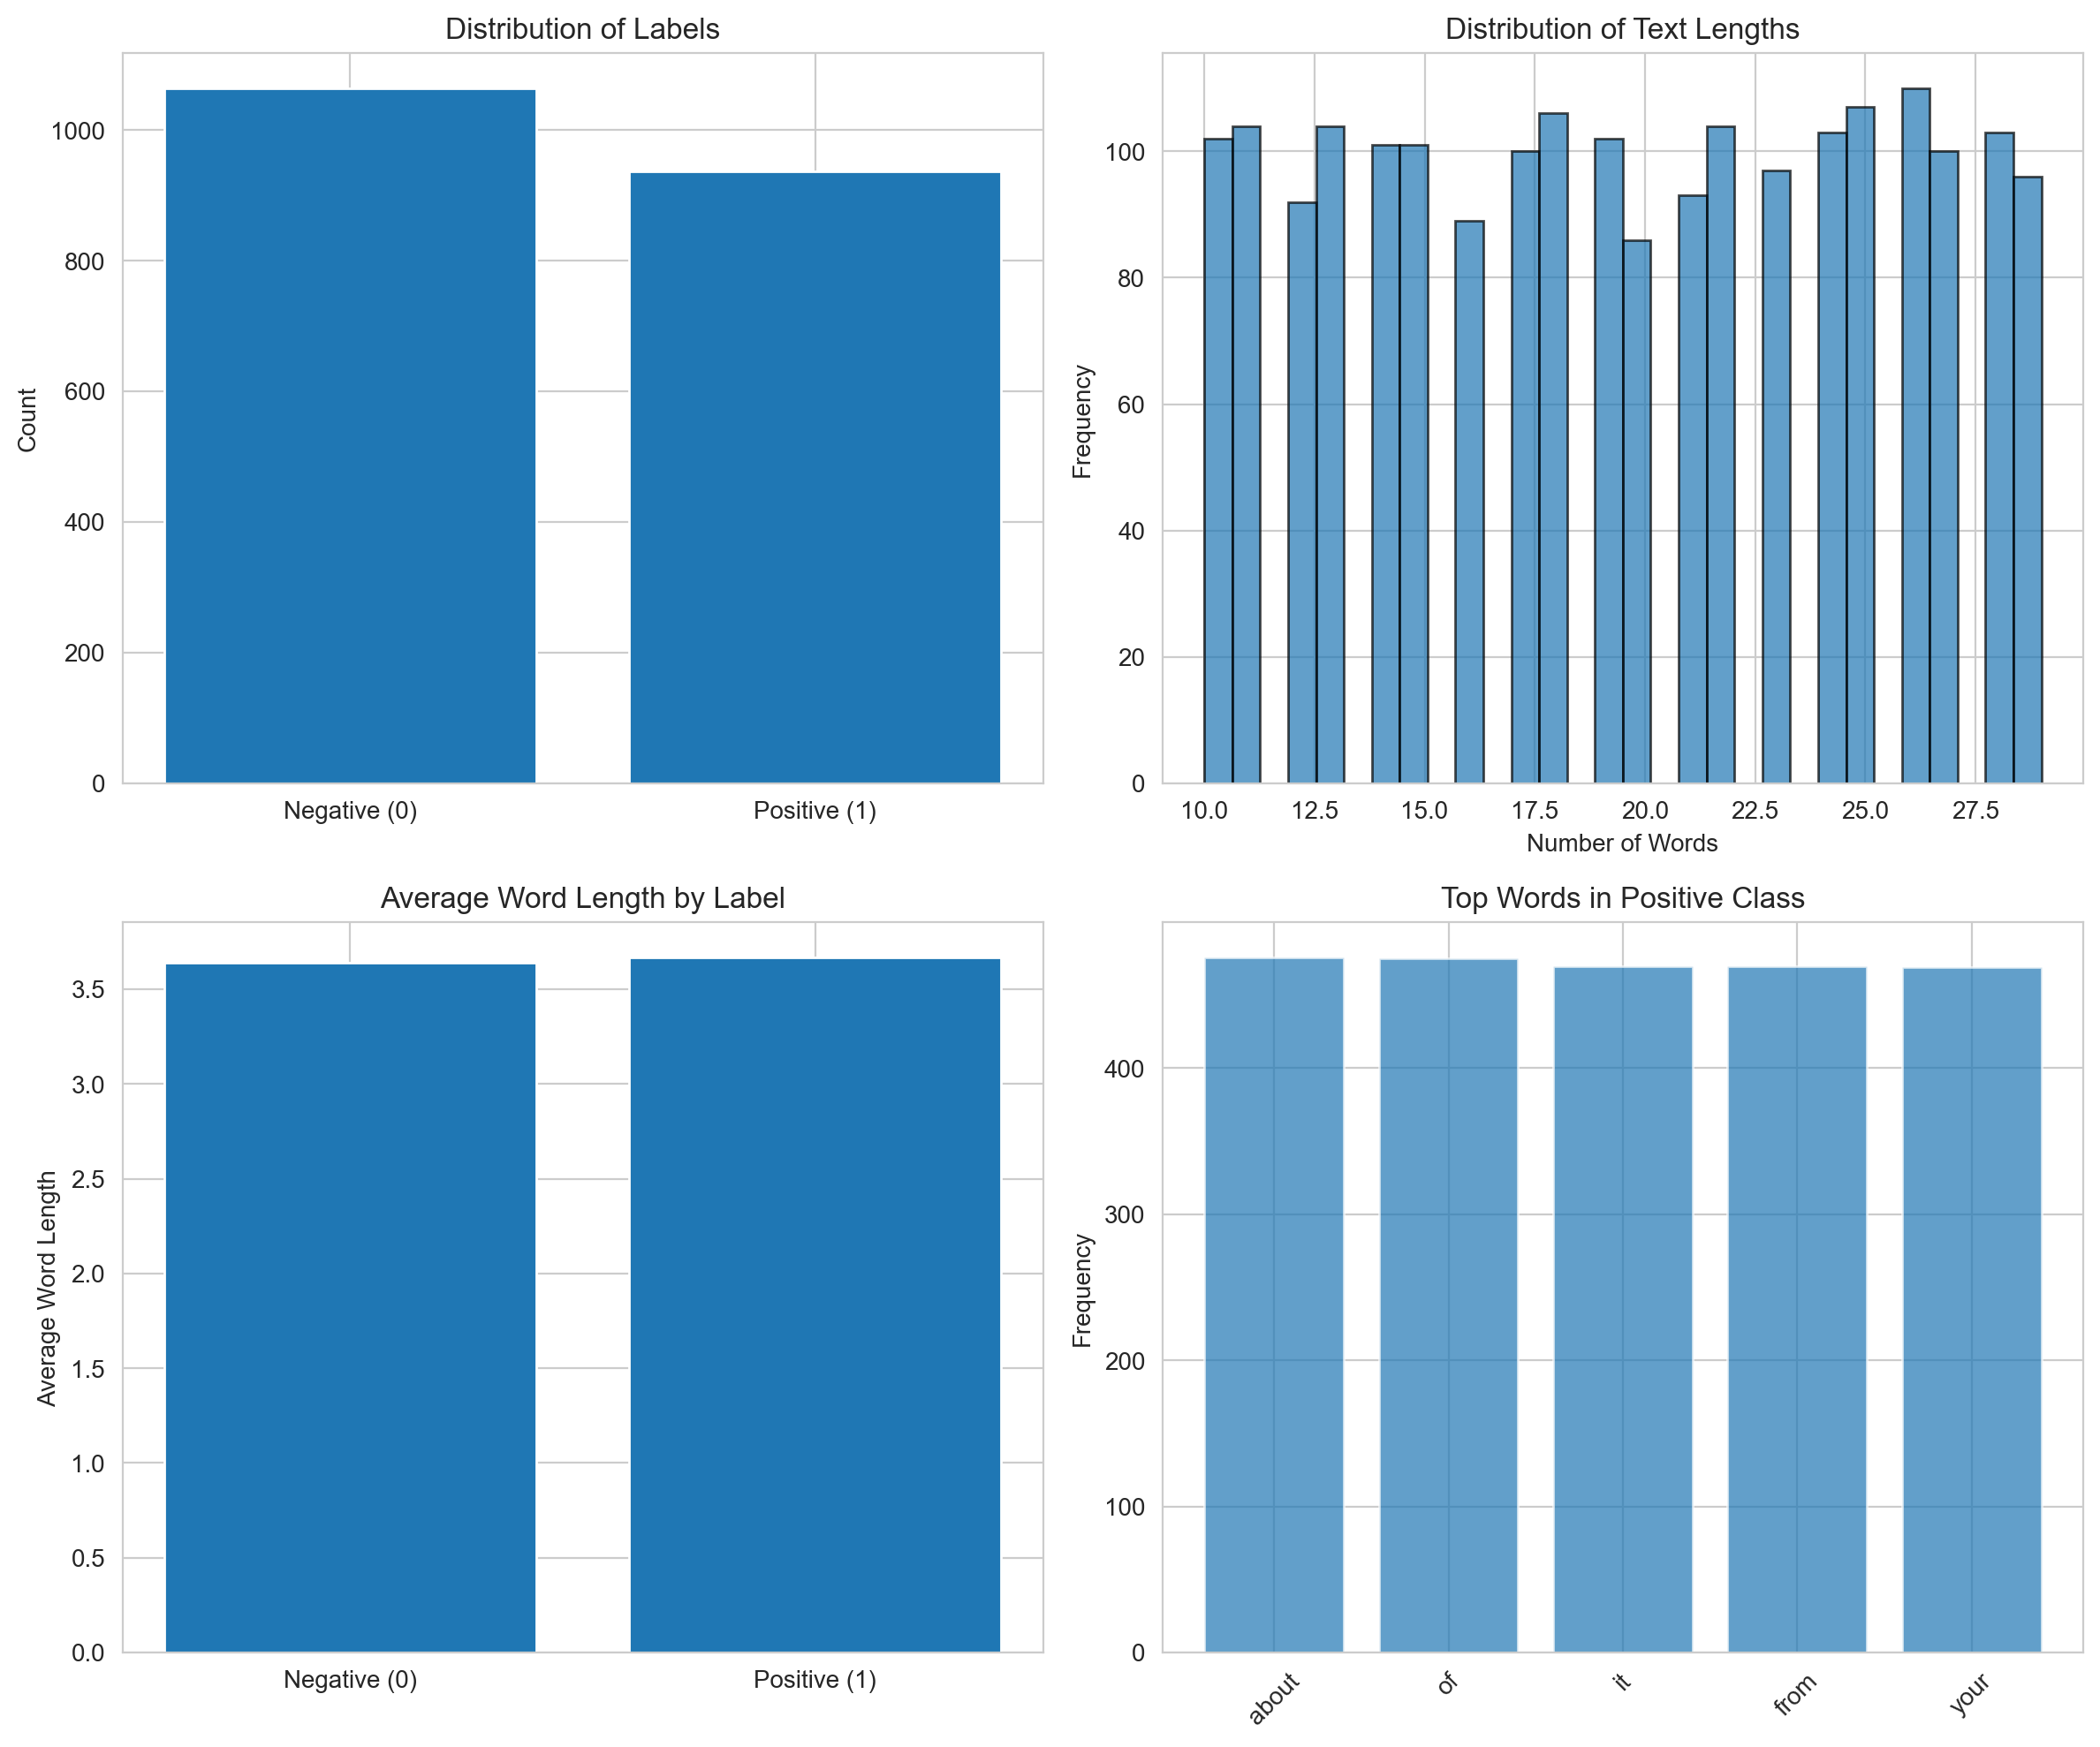

Average text length: 19.54
Most common words in positive class: [('about', 476), ('of', 475), ('it', 470), ('from', 470), ('your', 469)]
Most common words in negative class: [('or', 429), ('through', 425), ('a', 417), ('her', 416), ('between', 415)]


In [4]:
# Data preprocessing pipeline
def create_data_loader(X, y, batch_size=32, train_ratio=0.8):
    """
    Create train and test data loaders
    """
    # Split the data
    n_samples = len(X)
    n_train = int(train_ratio * n_samples)

    # Shuffle indices
    indices = torch.randperm(n_samples)
    train_indices = indices[:n_train]
    test_indices = indices[n_train:]

    # Create datasets
    train_dataset = TensorDataset(X[train_indices], y[train_indices])
    test_dataset = TensorDataset(X[test_indices], y[test_indices])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = create_data_loader(X, y, batch_size=32)

print("Training set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))
print("Batch size:", 32)

# Exploratory Data Analysis
fig, axes = plt.subplots(2, 2)

# Distribution of labels
axes[0,0].bar(['Negative (0)', 'Positive (1)'], df['label'].value_counts().values)
axes[0,0].set_title('Distribution of Labels')
axes[0,0].set_ylabel('Count')

# Distribution of text lengths
axes[0,1].hist(df['text_length'], bins=30, edgecolor='black', alpha=0.7)
axes[0,1].set_title('Distribution of Text Lengths')
axes[0,1].set_xlabel('Number of Words')
axes[0,1].set_ylabel('Frequency')

# Average word length by label
df['avg_word_length'] = df['text'].apply(lambda x: np.mean([len(word) for word in x.split()]))
avg_word_len_by_label = df.groupby('label')['avg_word_length'].mean()
axes[1,0].bar(['Negative (0)', 'Positive (1)'], avg_word_len_by_label.values)
axes[1,0].set_title('Average Word Length by Label')
axes[1,0].set_ylabel('Average Word Length')

# Most common words in each class
def get_common_words(texts, labels, label_val, top_n=10):
    label_texts = [text for text, label in zip(texts, labels) if label == label_val]
    all_words = []
    for text in label_texts:
        all_words.extend(preprocess_text(text).split())
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

pos_common = get_common_words(df['text'], df['label'], 1)
neg_common = get_common_words(df['text'], df['label'], 0)

# Show top words for positive class
pos_words, pos_counts = zip(*pos_common[:5])
axes[1,1].bar(pos_words, pos_counts, alpha=0.7, label='Positive')
axes[1,1].set_title('Top Words in Positive Class')
axes[1,1].set_ylabel('Frequency')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"Average text length: {df['text_length'].mean():.2f}")
print(f"Most common words in positive class: {pos_common[:5]}")
print(f"Most common words in negative class: {neg_common[:5]}")

In [5]:
# Define Transformer model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            -(np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=8, num_layers=2, num_classes=2, max_len=50, dropout=0.1):
        super(TransformerClassifier, self).__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, src):
        # Embedding and positional encoding
        src = self.embedding(src) * np.sqrt(self.d_model)
        src = self.pos_encoder(src)
        src = self.dropout(src)

        # Transformer encoder
        output = self.transformer_encoder(src)

        # Use the output of the first token (typically the [CLS] equivalent) or average pooling
        # Here we use average pooling across sequence dimension
        output = torch.mean(output, dim=1)

        # Classification
        output = self.fc(output)

        return output

# Initialize the model
d_model = 128
nhead = 8
num_layers = 2
num_classes = 2
dropout = 0.1

model = TransformerClassifier(
    vocab_size=vocab_size,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    num_classes=num_classes,
    max_len=max_length,
    dropout=dropout
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Display model architecture
print("Model Architecture:")
print(model)
print(f"\nTotal number of parameters: {sum(p.numel() for p in model.parameters())}")

Model Architecture:
TransformerClassifier(
  (embedding): Embedding(76, 128)
  (pos_encoder): PositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Total number of parameters: 1196034


In [6]:
# Training the Transformer model
num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()

    epoch_val_loss = val_loss / len(test_loader)
    epoch_val_acc = 100 * correct_val / total_val

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

Epoch [1/20], Train Loss: 0.7571, Train Acc: 50.88%, Val Loss: 0.6649, Val Acc: 62.00%
Epoch [2/20], Train Loss: 0.4580, Train Acc: 78.44%, Val Loss: 0.1987, Val Acc: 90.00%
Epoch [3/20], Train Loss: 0.1166, Train Acc: 95.31%, Val Loss: 0.0106, Val Acc: 99.50%
Epoch [4/20], Train Loss: 0.0084, Train Acc: 99.69%, Val Loss: 0.0004, Val Acc: 100.00%
Epoch [5/20], Train Loss: 0.0048, Train Acc: 99.88%, Val Loss: 0.0013, Val Acc: 100.00%
Epoch [6/20], Train Loss: 0.0546, Train Acc: 98.00%, Val Loss: 0.0251, Val Acc: 99.00%
Epoch [7/20], Train Loss: 0.0305, Train Acc: 99.12%, Val Loss: 0.0102, Val Acc: 99.50%
Epoch [8/20], Train Loss: 0.0160, Train Acc: 99.62%, Val Loss: 0.0074, Val Acc: 99.50%
Epoch [9/20], Train Loss: 0.0130, Train Acc: 99.69%, Val Loss: 0.0226, Val Acc: 99.50%
Epoch [10/20], Train Loss: 0.0169, Train Acc: 99.56%, Val Loss: 0.0133, Val Acc: 99.25%
Epoch [11/20], Train Loss: 0.0178, Train Acc: 99.56%, Val Loss: 0.0015, Val Acc: 100.00%
Epoch [12/20], Train Loss: 0.0143, Tra

Model Performance Metrics:
Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       192
    Positive       1.00      1.00      1.00       208

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



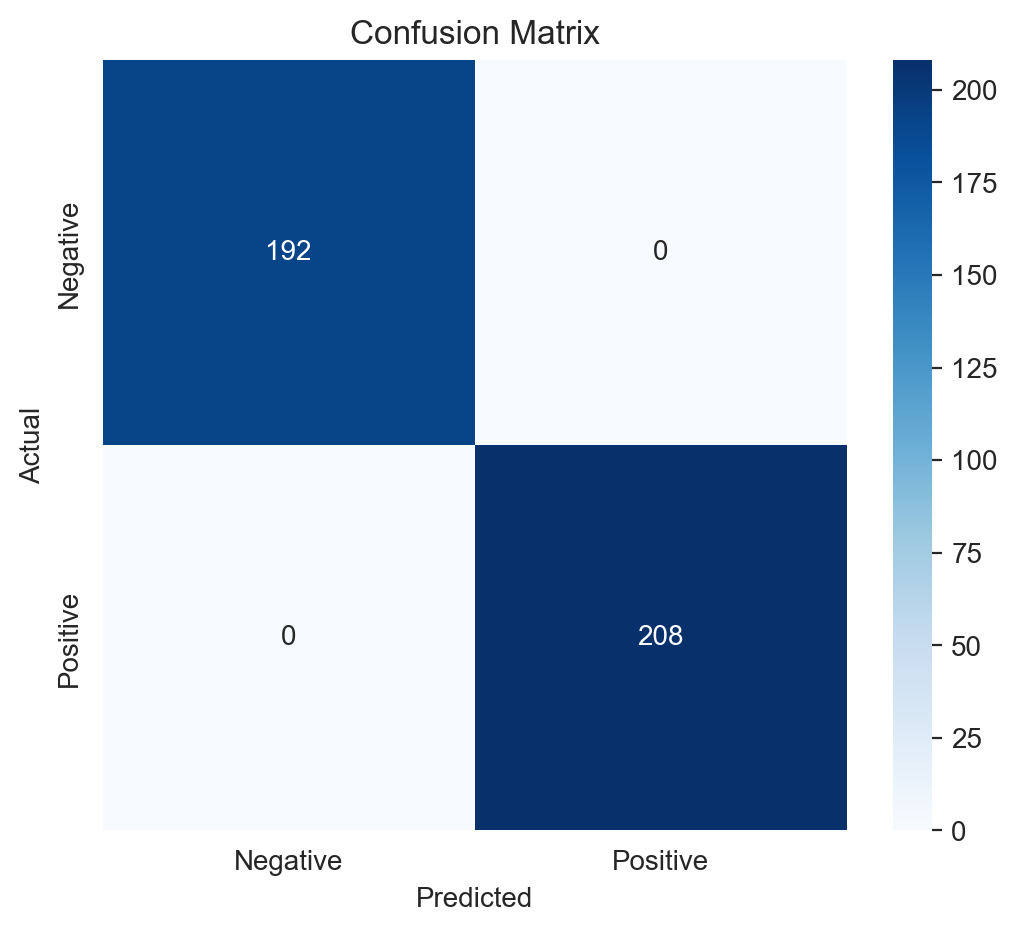

In [7]:
# Evaluate the model on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output, 1)

        all_preds.extend(predicted.numpy())
        all_labels.extend(target.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

test_accuracy = accuracy_score(all_labels, all_preds)
print("Model Performance Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

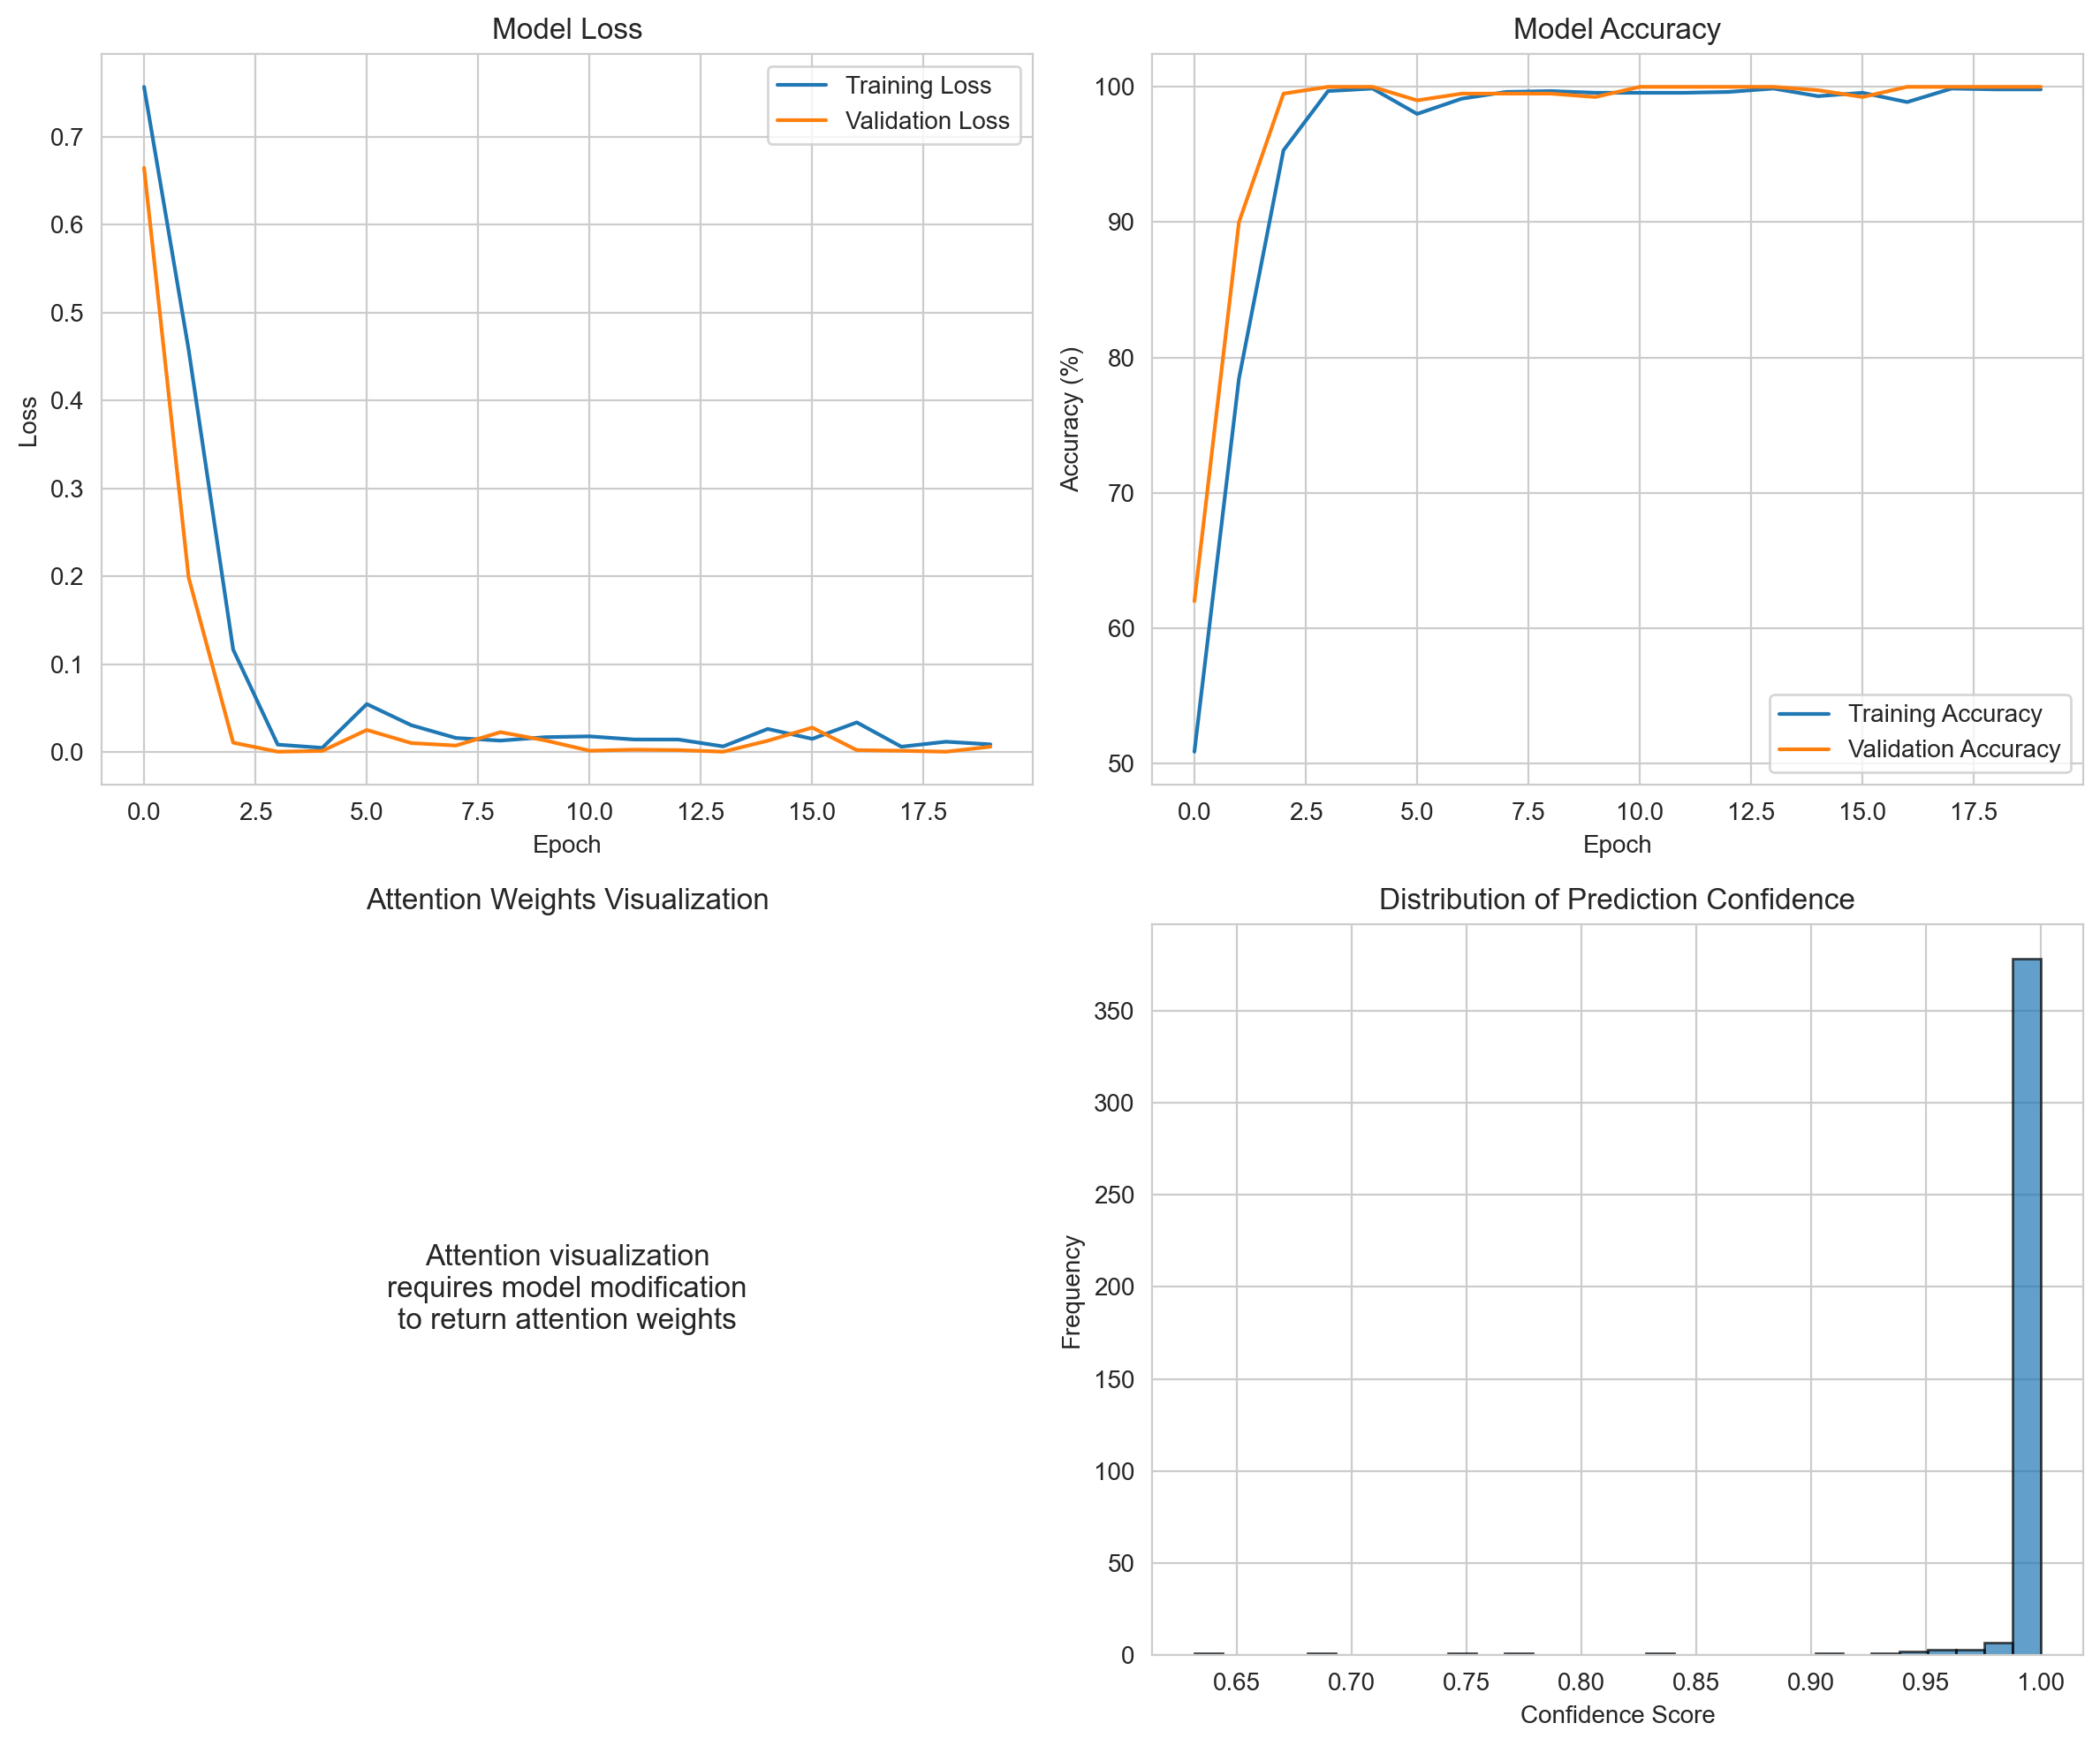


Example Predictions:
Text: she in an among them great with those and they him...
  Predicted: Positive (Confidence: 1.000)
  Actual: Positive

Text: to from him the it a with or or it that disgusting...
  Predicted: Negative (Confidence: 1.000)
  Actual: Negative

Text: that me these an your abysmal of above from they h...
  Predicted: Negative (Confidence: 1.000)
  Actual: Negative

Text: my before they after above she her through among h...
  Predicted: Negative (Confidence: 1.000)
  Actual: Negative

Text: for disgusting from into by with it an these she t...
  Predicted: Negative (Confidence: 1.000)
  Actual: Negative



In [8]:
# Visualization of results
fig, axes = plt.subplots(2, 2)

# Training history - loss
axes[0,0].plot(train_losses, label='Training Loss')
axes[0,0].plot(val_losses, label='Validation Loss')
axes[0,0].set_title('Model Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()

# Training history - accuracy
axes[0,1].plot(train_accuracies, label='Training Accuracy')
axes[0,1].plot(val_accuracies, label='Validation Accuracy')
axes[0,1].set_title('Model Accuracy')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy (%)')
axes[0,1].legend()

# Attention visualization (simplified - showing average attention weights)
# For this simple example, we'll visualize the average attention across all heads
# In practice, you would need to modify the model to return attention weights
axes[1,0].text(0.5, 0.5, 'Attention visualization\nrequires model modification\nto return attention weights',
               horizontalalignment='center', verticalalignment='center',
               transform=axes[1,0].transAxes, fontsize=12)
axes[1,0].set_title('Attention Weights Visualization')
axes[1,0].axis('off')

# Distribution of prediction confidence
model.eval()
all_probs = []
with torch.no_grad():
    for data, _ in test_loader:
        output = model(data)
        probs = F.softmax(output, dim=1)
        all_probs.append(probs.numpy())

all_probs = np.vstack(all_probs)
confidence_scores = np.max(all_probs, axis=1)  # Max probability as confidence

axes[1,1].hist(confidence_scores, bins=30, edgecolor='black', alpha=0.7)
axes[1,1].set_title('Distribution of Prediction Confidence')
axes[1,1].set_xlabel('Confidence Score')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Show some example predictions
print("\nExample Predictions:")
test_iter = iter(test_loader)
sample_data, sample_targets = next(test_iter)

model.eval()
with torch.no_grad():
    sample_outputs = model(sample_data[:5])
    sample_probs = F.softmax(sample_outputs, dim=1)
    _, sample_preds = torch.max(sample_outputs[:5], 1)

# Decode the first few samples back to text
for i in range(min(5, len(sample_data))):
    # Convert token indices back to text
    tokens = []
    for idx in sample_data[i]:
        if idx.item() in [vocab[token] for token in vocab]:
            # Find the token corresponding to the index
            token = [token for token, id in vocab.items() if id == idx.item()]
            if token:
                tokens.append(token[0])
        else:
            tokens.append('<UNK>')

    # Remove padding tokens
    tokens = [t for t in tokens if t != '<PAD>']
    original_text = ' '.join(tokens)

    predicted_class = 'Positive' if sample_preds[i].item() == 1 else 'Negative'
    actual_class = 'Positive' if sample_targets[i].item() == 1 else 'Negative'
    confidence = sample_probs[i][sample_preds[i]].item()

    print(f"Text: {original_text[:50]}...")
    print(f"  Predicted: {predicted_class} (Confidence: {confidence:.3f})")
    print(f"  Actual: {actual_class}")
    print()

In [9]:
# Model interpretation and insights
print("Transformer Model Configuration:")
print(f"Vocabulary size: {vocab_size}")
print(f"Embedding dimension: {d_model}")
print(f"Number of attention heads: {nhead}")
print(f"Number of transformer layers: {num_layers}")
print(f"Maximum sequence length: {max_length}")
print(f"Number of classes: {num_classes}")

print(f"\nFinal Performance:")
print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

# Show the most important words for each class based on embedding weights
# This is a simplified approach - in practice, attention weights would provide better insights
embedding_weights = model.embedding.weight.data.cpu().numpy()
print(f"\nEmbedding weights shape: {embedding_weights.shape}")

# Find the most important embeddings for each class
# This is a simplified interpretation - in practice, attention weights provide better insights
class_weights = model.fc.weight.data.cpu().numpy()
print(f"Classification weights shape: {class_weights.shape}")

# Show some sample embeddings
print(f"\nSample embedding for 'excellent': {embedding_weights[vocab.get('excellent', 1)][:5]}...")
print(f"Sample embedding for 'terrible': {embedding_weights[vocab.get('terrible', 1)][:5]}...")

Transformer Model Configuration:
Vocabulary size: 76
Embedding dimension: 128
Number of attention heads: 8
Number of transformer layers: 2
Maximum sequence length: 50
Number of classes: 2

Final Performance:
Final Training Accuracy: 99.81%
Final Validation Accuracy: 100.00%

Embedding weights shape: (76, 128)
Classification weights shape: (2, 128)

Sample embedding for 'excellent': [-0.42222905  0.40698266  1.6060958  -0.28934395 -0.24975711]...
Sample embedding for 'terrible': [-1.1994724 -0.9915238  0.631276   1.7042731 -1.1386131]...
